BBB Project Part 2
===

- Shows performance of bayes by backprop, a method using Variational Inference on a network

## Import files: same as other BBB project parts

In [16]:
# Add local folders to path
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [17]:
from collections import OrderedDict

import pymc3 as pm
import theano
import theano.tensor as tt

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import mode
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

%matplotlib inline

In [18]:
print('PyMC3 v{}\nTheano v{}'.format(pm.__version__,theano.__version__))

PyMC3 v3.5
Theano v1.0.3


In [19]:
# Set random seeds
np.random.seed(42)
pm.set_tt_rng(42)

In [20]:
# Avoid warnings on batches below
from warnings import filterwarnings
filterwarnings('ignore')

In [21]:
# Use tensorflow to import image datasets
import tensorflow as tf

reshape_train_imgs = lambda img : img.reshape(img.shape[0],-1)
imgvec2img = lambda vec : vec.reshape((np.sqrt(vec.shape[0]).astype(int),np.sqrt(vec.shape[0]).astype(int)))
floatX = theano.config.floatX

dataset = 'fashion_mnist'

if dataset == 'mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train,X_test = reshape_train_imgs(X_train),reshape_train_imgs(X_test)
    label_dict = OrderedDict({i:str(i) for i in range(10)})
    
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
    
    n_output = len(label_dict)
    
elif dataset == 'fashion_mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X_train,X_test = reshape_train_imgs(X_train),reshape_train_imgs(X_test)
    label_dict = OrderedDict({0: 'T-shirt/top',
                              1: 'Trouser',
                              2: 'Pullover',
                              3: 'Dress',
                              4: 'Coat',
                              5: 'Sandal',
                              6: 'Shirt',
                              7: 'Sneaker',
                              8: 'Bag',
                              9: 'Ankle boot'})
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
    
    n_output = len(label_dict)

(n_train,n_input) = X_train.shape
print("N Input for {} = {}".format(dataset,n_input))

N Input for fashion_mnist = 784


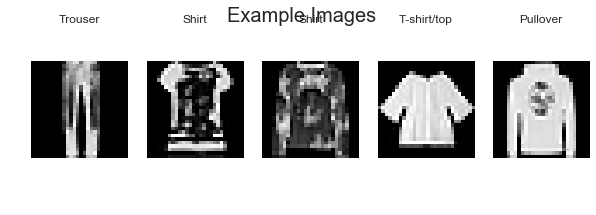

In [13]:
# PLot random subset of images
n_plot_samples = 5
rand_samps = np.random.choice(X_train.shape[0],size=n_plot_samples)

figsize = (10,3); fontsize = 16;
f, axs = plt.subplots(1,n_plot_samples,sharex=True,figsize=figsize);
for rs,ax in zip(rand_samps,axs):
    ax.imshow(imgvec2img(X_train[rs]),cmap='gray');
    ax.axis('off')
    ax.set_title(label_dict[y_train[rs]]);
    sns.despine();
f.suptitle("Example Images",fontsize=fontsize+4);

Use %load magic here to load `bbb_nn.py`. Delete are re-run a cell as below for updates:
```python
%load bbb_nn.py
```

In [14]:
# %load bbb_nn.py
def construct_nn(ann_input, ann_output, n_input, n_output, n_train, n_hidden_1=64, n_hidden_2=32):
    
    # Initialize random weights between each layer
    init_w_1 = np.random.randn(n_input, n_hidden_1).astype(theano.config.floatX)
    init_w_2 = np.random.randn(n_hidden_1, n_hidden_2).astype(theano.config.floatX)
    init_out = np.random.randn(n_hidden_2,n_output).astype(theano.config.floatX)
    
    # Initialize bias for each layer
    init_b_1 = np.random.randn(n_hidden_1).astype(theano.config.floatX)
    init_b_2 = np.random.randn(n_hidden_2).astype(theano.config.floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        w_0_1 = pm.Normal('w_0_1', 0, sd=1, shape=(n_input, n_hidden_1), testval=init_w_1)
        # Bias from in first layer
        b_1 = pm.Normal('b_1', 0, sd=1, shape=(n_hidden_1), testval=init_b_1)
        
        # Weights from 1st to 2nd layer
        w_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden_1, n_hidden_2), testval=init_w_2)
        # Bias from in first layer
        b_2 = pm.Normal('b_2', 0, sd=1, shape=(n_hidden_2), testval=init_b_2)
        
        # Weights from hidden layer to output
        w_2_out = pm.Normal('w_2_out', 0, sd=1.2,shape=(n_hidden_2,n_output),testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,w_0_1)+b_1)
        act_2 = pm.math.tanh(pm.math.dot(act_1,w_1_2)+b_2)
        
        # Softmax is required at last layer
        act_out = tt.nnet.softmax(pm.math.dot(act_2,w_2_out))
        
        # Classification
        out = pm.Categorical('out',act_out,observed=ann_output,total_size=n_train)
        
    return neural_network

## Active Learning

In this section we will see how having an estiamte of uncertainty can help to choose training data that efficiently reduces uncertainty, and consequently improves performance. We will begin with a proof-of-concept exercise using the fashion_mnist dataset. Next we will apply this principle in a more useful scenario to see how active learning can drive efficient exploration in a reinforcement learning example. 

### Fashion MNIST active learning example

Here we will chunk our training data into 5 chunks randomly. We will 1) train a network using one of these chunks, 2) test the uncertainty of the network output on each of the remaining 4 chunks, 3) continue training the original using the training data with the highest uncertainty, and 4) repeat sets 2-3 until all training data is used. We will also train one network on all training data chunks in a random order to serve as a comparison. After each training session we will evaluate the test performance to see how quickly the network is learning. 

In [9]:
# Run a small number of networks to see which is the best
layers_mat = [[16,8],[32,16],[64,32],[128,64],[128,92],[128,128],[256,92]]
layers_dict = OrderedDict({i : "L1:{},L2:{}".format(lm[0],lm[1]) for i,lm in enumerate(layers_mat)})

minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(y_train, batch_size=50)

nn_idx = 4 # larger networks fail to sample for TBD reasons
lm = layers_mat[nn_idx]
ld = layers_dict[nn_idx]

(n_train,n_input) = X_train.shape
NN_model = construct_nn(minibatch_x, minibatch_y, n_input, n_output, n_train, n_hidden_1=lm[0], n_hidden_2=lm[1])

NN_model.name = ld
print(NN_model.name)

L1:128,L2:92


In [10]:
# convergence not great, use a different method for conv check after:
# https://docs.pymc.io/notebooks/variational_api_quickstart.html
with NN_model:
    advi = pm.ADVI()
    
# After the bayes by BackProp paper!
print(advi.approx.shared_params)

# To better look at convergence, we keep track of parameter mean and std
ev_mean = advi.approx.mean.eval # callable that returns mean
ev_std = advi.approx.std.eval # callable that returns std
tracker = pm.callbacks.Tracker(mean=ev_mean,std=ev_std)
print(tracker.whatchdict)

n_approx_iter = 10000
with NN_model:
    approx = advi.fit(n=n_approx_iter, callbacks=[tracker])

{'mu': mu, 'rho': rho}
{'mean': <bound method Variable.eval of mu>, 'std': <bound method Variable.eval of softplus.0>}


Average Loss = 283.53: 100%|██████████| 10000/10000 [03:39<00:00, 45.57it/s]
Finished [100%]: Average Loss = 283.22


In [11]:
get_weight_mean = lambda i : [t[i] for t in tracker['mean']]
get_weight_stds = lambda i : [t[i] for t in tracker['std']]

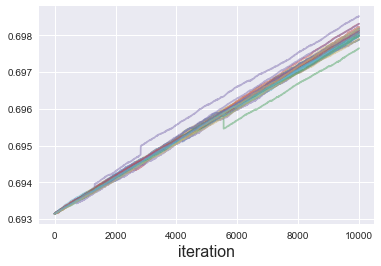

In [12]:
# Not sure this is doing what we want...
figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1)
for i in range(30):
    ax.plot(get_weight_stds(i),alpha=0.5,label=i)
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

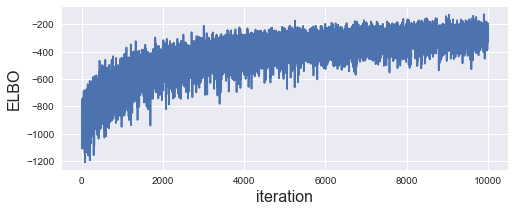

In [13]:
# plotting the training progress
elbo_1 = -advi.hist

figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1,figsize=figsize);

ax.plot(elbo_1,label='1')
ax.set_ylabel('ELBO',fontsize=fontsize)
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

In [14]:
# Run for a few more samples if desired
run_again = False
if run_again:
    approx.refine(n=int(n_approx_iter/2));
    elbo_2 = -advi.hist
    plt.plot(elbo_2,label='2')
    plt.ylabel('ELBO')
    plt.xlabel('iteration')

In [15]:
# Draw samples from variational posterior (the weights in the network)
n_draws = 1000 # > 2k hangs for almost all network sizes on my 2018 MBP -SH
trace = approx.sample(draws=n_draws)

### Look at training set performance

In [16]:
# network at performance on the training set
(n_train,n_input) = X_train.shape
train_x = theano.shared(X_train)
train_y = theano.shared(y_train)
NN_model_train = construct_nn(train_x, train_y, n_input, n_output, n_train, n_hidden_1=lm[0],n_hidden_2=lm[1])
with NN_model_train:
    ppc_train = pm.sample_ppc(trace, samples=100)

100%|██████████| 100/100 [05:36<00:00,  3.28s/it]


In [17]:
# Prediction is mode of each
train_y_pred = mode(ppc_train['out'], axis=0).mode[0,:]

mean_train_perf = np.mean(train_y_pred==y_train)
print("Network Training Set Performance: {:f}".format(mean_train_perf))

Network Training Set Performance: 0.745917


### Look at test set performance

In [18]:
# network at performance on the test set
(n_train,n_input) = X_test.shape
test_x = theano.shared(X_test)
test_y = theano.shared(y_test)
NN_model_test = construct_nn(test_x, test_y, n_input, n_output, n_train, n_hidden_1=lm[0],n_hidden_2=lm[1])
with NN_model_test:
    ppc_test = pm.sample_ppc(trace, samples=100)

100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


In [19]:
# Prediction is mode of each
test_y_pred = mode(ppc_test['out'], axis=0).mode[0,:]

mean_test_perf = np.mean(test_y_pred==y_test)
print("Network Test Set Performance: {:f}".format(mean_test_perf))

Network Test Set Performance: 0.732400


NameError: name 'test_y_pred' is not defined

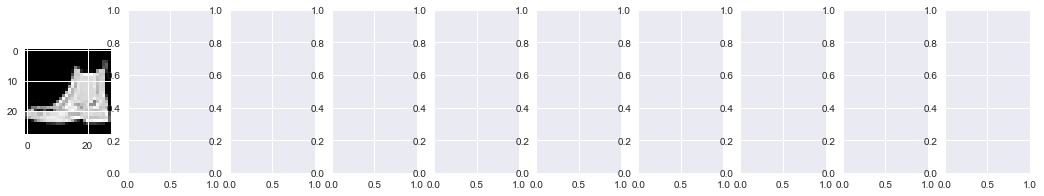

In [15]:
# PLot random subset of images
n_plot_samples = 10
rand_samps = np.random.choice(X_test.shape[0],size=n_plot_samples)

figsize = (18,3); fontsize = 16;
f, axs = plt.subplots(1, n_plot_samples, figsize=figsize);

for rs,ax in zip(rand_samps,axs):
    ax.imshow(imgvec2img(X_train[rs]),cmap='gray');
    tl = "{}: {},\n{}: {}".format(test_y_pred[rs],label_dict[test_y_pred[rs]],y_test[rs],label_dict[y_test[rs]])
    if test_y_pred[rs] == y_test[rs]:
        ax.set_title(tl,color='k');
    else:
        ax.set_title(tl,color='r');
    ax.axis('off');
    sns.despine();
    
f.suptitle("Example BBB Classification",fontsize=fontsize+4);